In [1]:
import random
import plotly
import warnings
import keras as k
import numpy as np
import pandas as pd
import seaborn as sns
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.model_selection import RepeatedKFold
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import roc_curve, roc_auc_score
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from models.linear_regression.linear_regression import LinearRegression as LR

import config as c
from sklearn.model_selection import train_test_split
from pipeline.Layer import Layer
from utils.cuda import turn_off_gpu
from models.svm.svm import SVM
from utils.metrics import roc_auc_score_at_K
from models.catboost_regression.catboost_regression import CatboostRegressor
from utils.preprocess import preprocess, add_columns, reset_averages
from models.keras_dense_classifier.keras_dense_classifier import KerasDenseClassifier as KDC
from visualization.utils import plot_correlation_matrix, plot_scatterplot_matrix

#turn_off_gpu()
init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')
plt.rcParams ['figure.figsize'] = (13,8)
sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('train.csv', sep=',')
pd.set_option('display.max_columns', 500)
df = add_columns(df)
df = preprocess(df)
df

,card_id,target,addr_region_reg,addr_region_fact,sas_limit_after_003_amt,sas_limit_last_amt,clnt_income_month_avg_net_amt,clnt_expense_month_avg_amt,clnt_experience_cur_mnth,clnt_experience_cur_year,clnt_experience_total_mnth,app_addr_region_reg,app_addr_region_fact,app_addr_region_sale,clnt_birth_year,addr_region_fact_encoding1,addr_region_fact_encoding2,addr_region_reg_encoding1,addr_region_reg_encoding2,app_addr_region_reg_encoding1,app_addr_region_reg_encoding2,app_addr_region_fact_encoding1,app_addr_region_fact_encoding2,app_addr_region_sale_encoding1,app_addr_region_sale_encoding2,loans_main_borrower,loans_active,last_loan_date,first_loan_date,max_overdue_status,ttl_officials,ttl_legals,ttl_bankruptcies,inquiry_recent_period,inquiry_3_month,inquiry_6_month,inquiry_9_month,inquiry_12_month,ttl_inquiries,ttl_auto_loan,ttl_mortgage,ttl_credit_card,ttl_consumer,worst_status_ever,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,fl_coborrower,fl_active_coborrower,pay_load,inquiry_1_week,inquiry_1_month,feature_10,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,makro_region,fo,region,feature_30,t_0,t_1,t_2,t_3,t_4,t_0=t_1,t_2=t_3,t_0=t_3,t_4_2000,t_4_364000,t_4_460000,t_4_430000,notnull,delivery_type_cat_1,delivery_type_cat_2,delivery_type_cat_3,channel_name_cat_0,channel_name_cat_1,channel_name_cat_2,channel_name_cat_3,channel_name_cat_4,channel_name_cat_5,channel_name_cat_6,channel_name_2_cat_0,channel_name_2_cat_1,channel_name_2_cat_2,channel_name_2_cat_3,channel_name_2_cat_4,channel_name_2_cat_5,channel_name_modified_2018_cat_0,channel_name_modified_2018_cat_1,channel_name_modified_2018_cat_2,channel_name_modified_2018_cat_3,channel_name_modified_2018_cat_4,clnt_education_name_cat_0,clnt_education_name_cat_1,clnt_education_name_cat_2,clnt_education_name_cat_3,clnt_education_name_cat_4,clnt_education_name_cat_5,clnt_education_name_cat_6,clnt_marital_status_name_cat_0,clnt_marital_status_name_cat_1,clnt_marital_status_name_cat_2,clnt_marital_status_name_cat_3,clnt_marital_status_name_cat_4,clnt_employment_type_name_cat_0,clnt_employment_type_name_cat_1,clnt_employment_type_name_cat_2,clnt_employment_type_name_cat_3,clnt_employment_type_name_cat_4,clnt_speciality_sphere_name_cat_0,clnt_speciality_sphere_name_cat_1,clnt_speciality_sphere_name_cat_10,clnt_speciality_sphere_name_cat_11,clnt_speciality_sphere_name_cat_12,clnt_speciality_sphere_name_cat_13,clnt_speciality_sphere_name_cat_14,clnt_speciality_sphere_name_cat_15,clnt_speciality_sphere_name_cat_16,clnt_speciality_sphere_name_cat_17,clnt_speciality_sphere_name_cat_18,clnt_speciality_sphere_name_cat_19,clnt_speciality_sphere_name_cat_2,clnt_speciality_sphere_name_cat_20,clnt_speciality_sphere_name_cat_21,clnt_speciality_sphere_name_cat_22,clnt_speciality_sphere_name_cat_23,clnt_speciality_sphere_name_cat_24,clnt_speciality_sphere_name_cat_25,clnt_speciality_sphere_name_cat_26,clnt_speciality_sphere_name_cat_27,clnt_speciality_sphere_name_cat_28,clnt_speciality_sphere_name_cat_3,clnt_speciality_sphere_name_cat_4,clnt_speciality_sphere_name_cat_5,clnt_speciality_sphere_name_cat_6,clnt_speciality_sphere_name_cat_7,clnt_speciality_sphere_name_cat_8,clnt_speciality_sphere_name_cat_9,clnt_sex_name_cat_0,clnt_sex_name_cat_1,prt_name_cat_0,prt_name_cat_1,prt_name_cat_2,prt_name_cat_3,prt_name_cat_4,prt_name_cat_5,prt_name_cat_6,prt_name_cat_7,prt_name_cat_8,prt_name_cat_9,feature_0_cat_0,feature_0_cat_1,feature_0_cat_10,feature_0_cat_12,feature_0_cat_13,feature_0_cat_14,feature_0_cat_15,feature_0_cat_16,feature_0_cat_3,feature_0_cat_6,feature_0_cat_7,feature_0_cat_8,feature_0_cat_9
0,cid_10620,1,107,107,1,1,3,0,0.0,0.0,0.0,107,107,45,46,560000,78750,560000,78750,560000,78750,560000,78750,260000,46000,0.88,0.78,193.0,2851.0,2,0.0,0.0,0.0,0.0,7.0,10.0,12.0,19.0,87,0,0,1,1,3,3,10,4,0,0,5,1,0,0,0

In [3]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()
c.SEED = random.randint(0, 10000)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr=LR()
lr.create_model(LR.default_model_constructor_parameters)
lr.fit_model(X, y)

-0.8633953348936861

In [4]:
cr=CatboostRegressor()
cr.create_model(CatboostRegressor.default_model_constructor_parameters)
cr.fit_model(X, y)

-0.898361963443315

In [5]:
predict = cr.predict(X_test)+lr.predict(X_test)*0.05
predict-=predict.min()
predict/=predict.max()
print(roc_auc_score_at_K(reset_averages(predict), y_test, rate=0.1))

0.9001032435531748


In [4]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()

scores = []
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=24)
for train, test in rkf.split(X):
    c.SEED = random.randint(0, 10000)
    cr=CatboostRegressor()
    cr.create_model(CatboostRegressor.default_model_constructor_parameters)
    cr.fit_model(X[train], y[train], test_size=0.0)
    score=cr.score(X[test], y[test
    scores.append(score)
print(float(np.mean(scores)))

KeyboardInterrupt: 

In [ ]:
print(roc_auc_score_at_K(reset_averages(predict), y_test, rate=0.1))

In [7]:
from pipeline.Layer import Layer

In [6]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()

scores = []
models = []
rkf = RepeatedKFold(n_splits=10, n_repeats=1)
for train, test in rkf.split(X):
    c.SEED = random.randint(0, 10000)
    cr=CatboostRegressor()
    cr.create_model(CatboostRegressor.default_model_constructor_parameters)
    cr.fit_model(X[train], y[train], test_size=0.0)
    models.append(cr)
    score=cr.score(X[test], y[test])
    scores.append(score)
print(float(np.mean(scores)))

-0.904104672361879


In [3]:
models = load('CatboostRegressor_10.joblib')

In [8]:
dump(models, 'CatboostRegressor_10.joblib')

['CatboostRegressor_10.joblib']

In [9]:
layer=Layer(models[:10])

In [10]:
predict=layer.predict(X)
predict=np.mean(list(predict.values()), axis=0)

In [18]:
print(roc_auc_score_at_K(reset_averages(models[1].predict(X)), y, rate=0.1))

0.9351232758453216


In [17]:
models[0].save_model()

In [17]:
corr = df.corr()
df = df[list(corr[abs(corr.iloc[:,0])>0.025].iloc[:,0].index)]

In [20]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()

from sklearn.model_selection import RepeatedKFold
scores = []
rkf = RepeatedKFold(n_splits=10, n_repeats=1)
for train, test in rkf.split(X):
    c.SEED = random.randint(0, 10000)
    cr=CatboostRegressor()
    cr.create_model(CatboostRegressor.default_model_constructor_parameters)
    cr.fit_model(X[train], y[train], test_size=0.0)
    score=cr.score(X[test], y[test])
    scores.append(score)
float(np.mean(scores))

-0.9001342906886473

In [76]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()

c.SEED = random.randint(0, 10000)
cr=CatboostRegressor()
cr.create_model(CatboostRegressor.default_model_constructor_parameters)
cr.fit_model(X, y)

0:	total: 11ms	remaining: 11s
999:	total: 9.11s	remaining: 0us


-0.9116723569731277

In [8]:
from catboost import CatBoostRegressor, CatBoostClassifier


model = CatBoostRegressor(iterations=1000, learning_rate=3e-2,
                           depth=6, loss_function="RMSE",eval_metric='AUC', random_state=42, verbose=100,
                           l2_leaf_reg = 3.0, min_data_in_leaf = 1, rsm = 1, diffusion_temperature=10000)

model.fit(X_train, y_train, eval_set=(X_test, y_test))
print(roc_auc_score_at_K(reset_averages(model.predict(X_test)), y_test, rate=0.1))

dump(model, 'catboost.joblib')

0:	test: 0.6688692	best: 0.6688692 (0)	total: 13.3ms	remaining: 13.3s
100:	test: 0.7175341	best: 0.7175341 (100)	total: 1.24s	remaining: 11s
200:	test: 0.7260615	best: 0.7260615 (200)	total: 2.33s	remaining: 9.26s
300:	test: 0.7307901	best: 0.7307901 (300)	total: 3.42s	remaining: 7.95s
400:	test: 0.7339479	best: 0.7339479 (400)	total: 4.55s	remaining: 6.79s
500:	test: 0.7363819	best: 0.7363937 (499)	total: 5.65s	remaining: 5.62s
600:	test: 0.7377508	best: 0.7377508 (600)	total: 6.69s	remaining: 4.44s
700:	test: 0.7385465	best: 0.7385465 (700)	total: 7.78s	remaining: 3.32s
800:	test: 0.7389158	best: 0.7389247 (797)	total: 8.85s	remaining: 2.2s
900:	test: 0.7393207	best: 0.7393414 (896)	total: 9.89s	remaining: 1.09s
999:	test: 0.7397720	best: 0.7397811 (998)	total: 10.9s	remaining: 0us

bestTest = 0.7397810659
bestIteration = 998

Shrink model to first 999 iterations.
0.9120683609569152


['catboost.joblib']

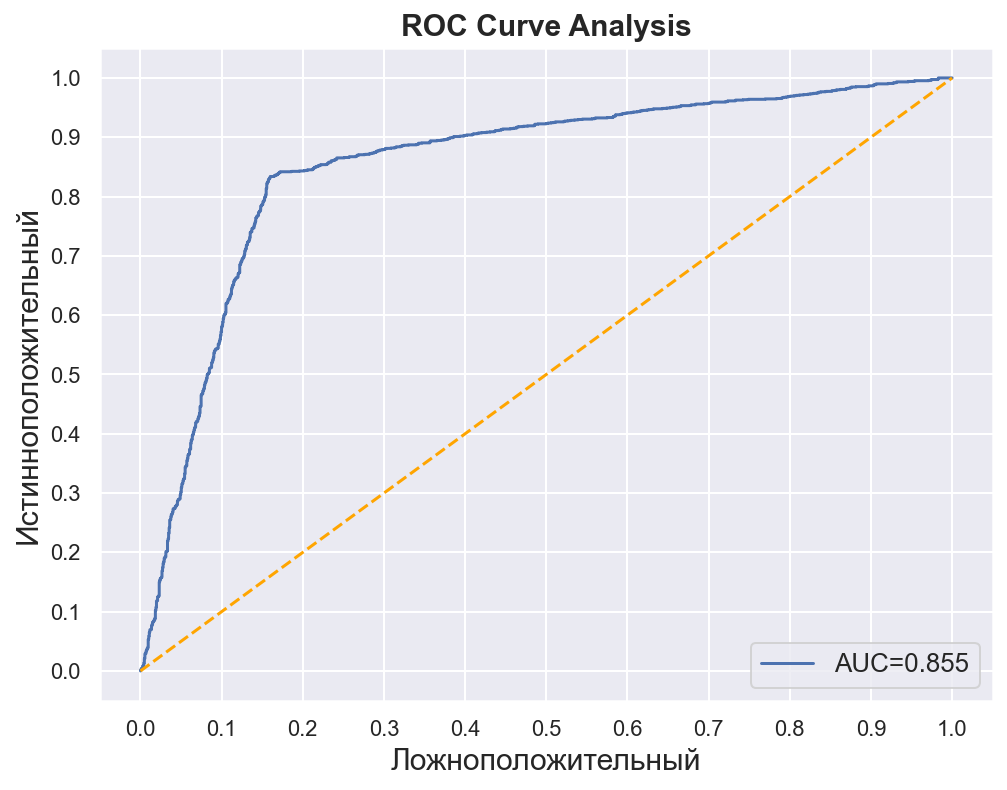

In [10]:
yproba = model.predict(X_test)
target = y_test
reset_averages(yproba)

order = np.argsort(-yproba)
top_k = int(0.10 * len(yproba))
yproba = yproba[order][:top_k]
target = target[order][:top_k]

fpr, tpr, _ = roc_curve(target,  yproba)
auc = roc_auc_score(target, yproba)
fig = plt.figure(figsize=(8,6))

plt.plot(fpr,          tpr, 
         label="AUC={:.3f}".format(auc))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')



plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Ложноположительный", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Истинноположительный", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()